In [1]:
from glob import glob
import fnmatch
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
imagePatches = glob('C:/Users/asus/Documents/Breast cancer classification/**/*.png', recursive=True)

In [3]:
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero) #saves the file location of all images with file name class0
classOne = fnmatch.filter(imagePatches, patternOne) #saves the file location of all images with file name class1

The function process_images takes as input the start and end index. It also reads the pixel values of the images and resizes them so that all images are of the same size. The array x contains the image data and array y contains the corresponding class of the images. 

In [4]:
def process_images(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    height = 50
    width = 50
    channels = 3
    x = [] #list to store image data
    y = [] #list to store corresponding class
    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        image = (cv2.resize(full_size_image, (width,height), interpolation=cv2.INTER_CUBIC))
        x.append(image)
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

In [5]:
X, Y = process_images(0,60000)

In [6]:
X = np.array(X)

In [7]:
X = X.astype(np.float32) #Casting the array to single precision takes half as much space

In [8]:
X /= 255. #Normalizing, which helps train the model faster and prevents the vanishing/ exploding gradient problem

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.15)

In [10]:
Y.count(0) #Checking the number of 0's in the array Y (this denotes number of malignant cases)

44478

In [11]:
Y.count(1) #Checking the number of 1's in the array Y (this denotes number of malignant cases)

15522

In [12]:
y_train.count(1) #Checking the number of 1's in the array y_train

13210

In [13]:
y_train.count(0) #Checking the number of 1's in the array y_train

37790

In [14]:
import keras
from keras.utils import to_categorical

E:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [15]:
#One-Hot-Encode y_train and y_test
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Dealing with class imbalance

Reshaping the image data to feed into RandomUnderSampler to deal with class imbalance

In [16]:
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)

The majority class is undersampled to make number of samples of both classes equal

In [17]:
from imblearn.under_sampling import RandomUnderSampler
random_under_sampler = RandomUnderSampler(ratio='majority')
X_trainRus, Y_trainRus = random_under_sampler.fit_sample(X_trainFlat, y_train)
X_testRus, Y_testRus = random_under_sampler.fit_sample(X_testFlat, y_test)

In [18]:
# One-hot-encoding
Y_trainRusHot = to_categorical(Y_trainRus, num_classes = 2)
Y_testRusHot = to_categorical(Y_testRus, num_classes = 2)

In [19]:
np.unique(Y_trainRus, return_counts=True) #checking the number of samples in each class to make sure RandomUnderSampling worked

(array([0, 1]), array([13210, 13210], dtype=int64))

Now we have equal number of 1's and 0's

The cells below reshapes X_trainRos and X_testRos to the original image shape of 50 x 50 x 3

In [20]:
for i in range(len(X_trainRus)):
    height, width, channels = 50,50,3
    X_trainRusReshaped = X_trainRus.reshape(len(X_trainRus),height,width,channels)

In [21]:
for i in range(len(X_testRus)):
    height, width, channels = 50,50,3
    X_testRusReshaped = X_testRus.reshape(len(X_testRus),height,width,channels)

# Model architecture

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

In [23]:
batch_size = 256
num_classes = 2
epochs = 80

In [24]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3),
                 activation='relu',
                 input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Flatten()) #this converts our 3D feature maps to 1D feature vectors for the dense layer below
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

Compiling the model

In [25]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.00001),
              metrics=['accuracy'])

Data augmentation on-the-fly

In [26]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=180,
    horizontal_flip=True,vertical_flip = True)

Early stopping to prevent overfitting and model checkpoint to save best model based on minimum val_loss

In [27]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=3, mode='min')
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

Fitting the model

In [28]:
training = model.fit_generator(datagen.flow(X_trainRusReshaped,Y_trainRusHot,batch_size=batch_size),
                    steps_per_epoch=len(X_trainRusReshaped) / batch_size, epochs=epochs,validation_data=(X_testRusReshaped, Y_testRusHot), verbose=1, callbacks=[early_stopping_monitor, model_checkpoint])

Epoch 1/80


E:\Anaconda\lib\site-packages\keras_preprocessing\image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
E:\Anaconda\lib\site-packages\keras_preprocessing\image.py:1139: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


104/103 [==============================] - 141s 1s/step - loss: 0.6915 - acc: 0.5022 - val_loss: 0.6883 - val_acc: 0.4999

Epoch 00001: val_loss improved from inf to 0.68831, saving model to best_model.h5
Epoch 2/80
104/103 [==============================] - 32s 309ms/step - loss: 0.6827 - acc: 0.5479 - val_loss: 0.6534 - val_acc: 0.7306

Epoch 00002: val_loss improved from 0.68831 to 0.65338, saving model to best_model.h5
Epoch 3/80
104/103 [==============================] - 32s 310ms/step - loss: 0.6096 - acc: 0.7203 - val_loss: 0.5330 - val_acc: 0.7623

Epoch 00003: val_loss improved from 0.65338 to 0.53301, saving model to best_model.h5
Epoch 4/80
104/103 [==============================] - 33s 315ms/step - loss: 0.5164 - acc: 0.7708 - val_loss: 0.4992 - val_acc: 0.7728

Epoch 00004: val_loss improved from 0.53301 to 0.49919, saving model to best_model.h5
Epoch 5/80
104/103 [==============================] - 32s 310ms/step - loss: 0.4954 - acc: 0.7813 - val_loss: 0.4940 - val_acc: 0

Plotting the training and validation loss

E:\Anaconda\lib\site-packages\keras_preprocessing\image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
E:\Anaconda\lib\site-packages\keras_preprocessing\image.py:1139: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


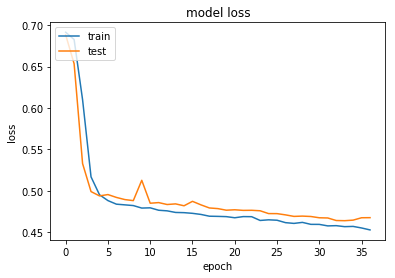

In [29]:
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Predicting on the test set and printing the confusion matrix

In [30]:
from keras.models import load_model
from sklearn import metrics
model = load_model('best_model.h5')

y_pred_one_hot = model.predict(X_testRusReshaped)
y_pred_labels = np.argmax(y_pred_one_hot, axis = 1)

y_true_labels = np.argmax(Y_testRusHot,axis=1)

confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
print(confusion_matrix)

[[1761  551]
 [ 416 1896]]
